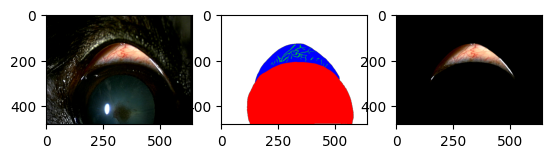

In [1]:
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt

mode = 'train'
ID = '0003'

eye_img = np.array(Image.open(f'data/{mode}/image/{ID}.png').convert('RGB'))
mask_img = np.array(Image.open(f'data/{mode}/label/{ID}.png'))

blue_mask = cv2.inRange(mask_img, np.array([0, 0, 255, 255]), np.array([0, 0, 255, 255]))
green_mask = cv2.inRange(mask_img, np.array([0, 255, 0, 255]), np.array([0, 255, 0, 255]))
conj_mask = green_mask | blue_mask
conj_mask = cv2.cvtColor(conj_mask, cv2.COLOR_GRAY2RGB)

conj_image = cv2.bitwise_and(eye_img, conj_mask)
plt.subplot(1, 3, 1)
plt.imshow(eye_img)
plt.subplot(1, 3, 2)
plt.imshow(mask_img)
plt.subplot(1, 3, 3)
plt.imshow(conj_image)
plt.show()

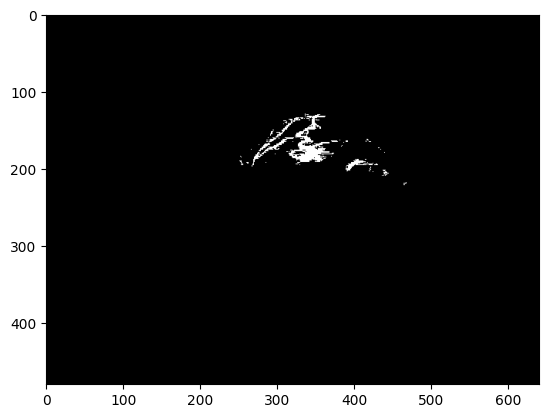

In [2]:
hsv_img = cv2.cvtColor(conj_image, cv2.COLOR_RGB2HSV)

# 赤色の範囲を定義（HSVでの赤は0付近と180付近）
lower_red1 = np.array([0, 120, 120]) 
upper_red1 = np.array([10, 255, 255])

red_mask = cv2.inRange(hsv_img, lower_red1, upper_red1)

plt.imshow(red_mask, cmap='gray')
plt.show()

In [3]:
import ipywidgets as widgets
from IPython.display import display

def update_mask(h_min, h_max, s_min, v_min):
    hsv_img = cv2.cvtColor(conj_image, cv2.COLOR_RGB2HSV)
    lower_red = np.array([h_min, s_min, v_min])
    upper_red = np.array([h_max, 255, 255])
    
    red_mask = cv2.inRange(hsv_img, lower_red, upper_red)
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(conj_image)
    plt.title('Original')
    plt.subplot(122)
    plt.imshow(red_mask, cmap='gray')
    plt.title('Red Mask')
    plt.show()

# スライダーの初期値を変更
h_min_slider = widgets.IntSlider(value=0, min=0, max=180, description='H min')
h_max_slider = widgets.IntSlider(value=10, min=0, max=180, description='H max')
s_min_slider = widgets.IntSlider(value=120, min=0, max=255, description='S min')
v_min_slider = widgets.IntSlider(value=120, min=0, max=255, description='V min')

# インタラクティブな表示を作成
widgets.interactive(update_mask, 
                   h_min=h_min_slider,
                   h_max=h_max_slider,
                   s_min=s_min_slider,
                   v_min=v_min_slider)

interactive(children=(IntSlider(value=0, description='H min', max=180), IntSlider(value=10, description='H max…

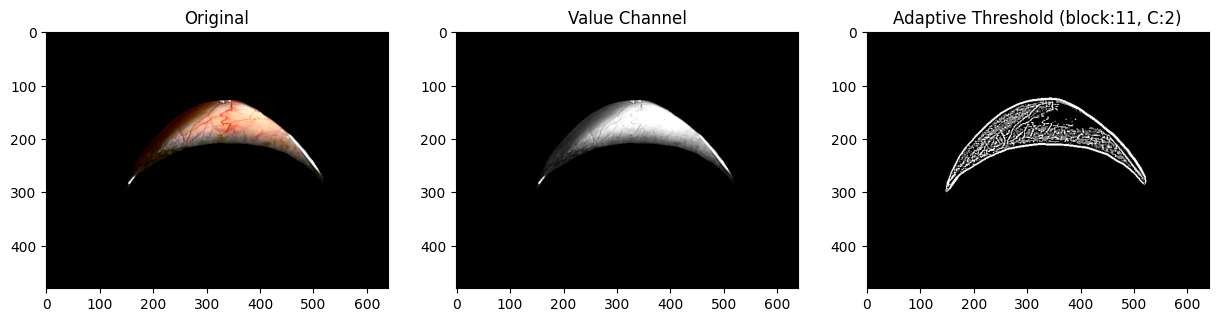

In [4]:
# 結膜マスク内の画像を取得
hsv_img = cv2.cvtColor(conj_image, cv2.COLOR_RGB2HSV)

# Value channelを取得
v_channel = hsv_img[:, :, 2]

# Adaptive Thresholdingを適用
block_size = 11  # 奇数である必要がある
C = 2
binary = cv2.adaptiveThreshold(
    v_channel,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    block_size,
    C
)

# 結果表示
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(conj_image)
plt.title('Original')
plt.subplot(132)
plt.imshow(v_channel, cmap='gray')
plt.title('Value Channel')
plt.subplot(133)
plt.imshow(binary, cmap='gray')
plt.title(f'Adaptive Threshold (block:{block_size}, C:{C})')
plt.show()

In [5]:
import ipywidgets as widgets
from IPython.display import display

def update_adaptive_threshold(block_size, C):
    # 元画像をHSVに変換してV channelを取得
    hsv_img = cv2.cvtColor(conj_image, cv2.COLOR_RGB2HSV)
    v_channel = hsv_img[:, :, 2]
    
    # block_sizeは奇数である必要がある
    block_size = block_size * 2 + 1
    
    # Adaptive Thresholdingを適用
    binary = cv2.adaptiveThreshold(
        v_channel,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        block_size,
        C
    )
    
    # 結膜マスクを適用
    binary = cv2.bitwise_and(binary, conj_mask[:,:,0])
    
    # 結果表示
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(conj_image)
    plt.title('Original')
    plt.subplot(122)
    plt.imshow(binary, cmap='gray')
    plt.title(f'Adaptive Threshold\nblock_size: {block_size}, C: {C}')
    plt.show()

# スライダーの作成
block_size_slider = widgets.IntSlider(
    value=5,  # 実際のblock_sizeは11になる (2*5 + 1)
    min=1,
    max=25,
    description='Block Size'
)

C_slider = widgets.FloatSlider(
    value=2,
    min=-10,
    max=10,
    step=0.5,
    description='C value'
)

# インタラクティブな表示を作成
widgets.interactive(
    update_adaptive_threshold,
    block_size=block_size_slider,
    C=C_slider
)

interactive(children=(IntSlider(value=5, description='Block Size', max=25, min=1), FloatSlider(value=2.0, desc…

In [6]:
def detect_vessels_two_stage(conj_image, h_min=0, h_max=10, s_min=120, block_size=11, C=2):
    # Stage 1: HSVで血管候補領域を抽出
    hsv_img = cv2.cvtColor(conj_image, cv2.COLOR_RGB2HSV)
    lower = np.array([h_min, s_min, 50])
    upper = np.array([h_max, 255, 255])
    hsv_mask = cv2.inRange(hsv_img, lower, upper)
    
    # HSVマスクを使って候補領域の画像を取得
    candidate_region = cv2.bitwise_and(conj_image, conj_image, mask=hsv_mask)
    
    # Stage 2: 候補領域内でAdaptiveThreshold
    gray = cv2.cvtColor(candidate_region, cv2.COLOR_RGB2GRAY)
    binary = cv2.adaptiveThreshold(
        gray,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        block_size,
        C
    )
    
    # 最終マスク（HSVマスクとの論理積）
    final_mask = cv2.bitwise_and(binary, hsv_mask)
    
    return hsv_mask, binary, final_mask

# 結果を表示する関数
def show_results(conj_image, hsv_mask, adaptive_mask, final_mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(141)
    plt.imshow(conj_image)
    plt.title('Original')
    plt.subplot(142)
    plt.imshow(hsv_mask, cmap='gray')
    plt.title('Stage 1: HSV Mask')
    plt.subplot(143)
    plt.imshow(adaptive_mask, cmap='gray')
    plt.title('Stage 2: Adaptive')
    plt.subplot(144)
    plt.imshow(final_mask, cmap='gray')
    plt.title('Final Result')
    plt.show()

# インタラクティブウィジェット
def update_detection(h_min, h_max, s_min, block_size, C):
    hsv_mask, adaptive_mask, final_mask = detect_vessels_two_stage(
        conj_image, h_min, h_max, s_min, block_size*2+1, C
    )
    show_results(conj_image, hsv_mask, adaptive_mask, final_mask)

# スライダーの作成
h_min_slider = widgets.IntSlider(value=0, min=0, max=180, description='H min')
h_max_slider = widgets.IntSlider(value=45, min=0, max=180, description='H max')
s_min_slider = widgets.IntSlider(value=80, min=0, max=255, description='S min')
block_size_slider = widgets.IntSlider(value=5, min=1, max=25, description='Block Size')
C_slider = widgets.FloatSlider(value=7, min=-10, max=10, step=0.5, description='C value')

# インタラクティブな表示を作成
widgets.interactive(
    update_detection,
    h_min=h_min_slider,
    h_max=h_max_slider,
    s_min=s_min_slider,
    block_size=block_size_slider,
    C=C_slider
)

interactive(children=(IntSlider(value=0, description='H min', max=180), IntSlider(value=45, description='H max…

In [7]:
def update_mask_with_clahe(h_min, h_max, s_min, v_min, clip_limit=2.0, tile_size=8):
    # 入力画像をHSVに変換
    hsv_img = cv2.cvtColor(conj_image, cv2.COLOR_RGB2HSV)
    
    # CLAHEオブジェクトを作成し、Vチャンネルに適用
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size, tile_size))
    hsv_img[:,:,2] = clahe.apply(hsv_img[:,:,2])
    
    # HSVでマスク作成
    lower_red = np.array([h_min, s_min, v_min])
    upper_red = np.array([h_max, 255, 255])
    red_mask = cv2.inRange(hsv_img, lower_red, upper_red)
    
    # 結果表示
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(conj_image)
    plt.title('Original')
    plt.subplot(132)
    plt.imshow(cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB))
    plt.title('CLAHE Enhanced')
    plt.subplot(133)
    plt.imshow(red_mask, cmap='gray')
    plt.title('Vessel Mask')
    plt.show()

# スライダーの作成
h_min_slider = widgets.IntSlider(value=0, min=0, max=180, description='H min')
h_max_slider = widgets.IntSlider(value=10, min=0, max=180, description='H max')
s_min_slider = widgets.IntSlider(value=120, min=0, max=255, description='S min')
v_min_slider = widgets.IntSlider(value=120, min=0, max=255, description='V min')
clip_limit_slider = widgets.FloatSlider(value=2.0, min=0.5, max=5.0, step=0.5, description='CLAHE clip')
tile_size_slider = widgets.IntSlider(value=8, min=4, max=16, description='Tile size')

# インタラクティブな表示を作成
widgets.interactive(
    update_mask_with_clahe,
    h_min=h_min_slider,
    h_max=h_max_slider,
    s_min=s_min_slider,
    v_min=v_min_slider,
    clip_limit=clip_limit_slider,
    tile_size=tile_size_slider
)

interactive(children=(IntSlider(value=0, description='H min', max=180), IntSlider(value=10, description='H max…

In [8]:
def show_correction_comparison(image, conj_mask, kernel_size=51, method='background'):
    # グレースケール変換
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    masked_gray = cv2.bitwise_and(gray, conj_mask[:,:,0])
    
    if method == 'background':
        # 背景推定
        background = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
        # 背景除去
        corrected = cv2.subtract(background, gray)
    else:  # tophat
        # 構造要素の作成
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        # トップハット変換
        corrected = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    
    # 結膜マスク適用
    corrected = cv2.bitwise_and(corrected, conj_mask[:,:,0])
    
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original')
    plt.subplot(132)
    plt.imshow(masked_gray, cmap='gray')
    plt.title('Original Grayscale')
    plt.subplot(133)
    plt.imshow(corrected, cmap='gray')
    plt.title(f'After {method} correction')
    plt.show()

# インタラクティブウィジェット
def update_correction(kernel_size, method):
    if kernel_size % 2 == 0:
        kernel_size += 1
    show_correction_comparison(conj_image, conj_mask, kernel_size, method)

# スライダーとドロップダウンの作成
kernel_slider = widgets.IntSlider(
    value=51, 
    min=3, 
    max=101, 
    step=2, 
    description='Kernel Size'
)
method_dropdown = widgets.Dropdown(
    options=['background', 'tophat'],
    value='background',
    description='Method'
)

# インタラクティブな表示を作成
widgets.interactive(
    update_correction,
    kernel_size=kernel_slider,
    method=method_dropdown
)

interactive(children=(IntSlider(value=51, description='Kernel Size', max=101, min=3, step=2), Dropdown(descrip…